# 0. Loading

First we activate the `examples` environment and then we load a couple of packages

In [142]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using Revise, PtyLab, Parameters, EllipsisNotation, Colors
using ImageShow, ImageCore, FFTW, BenchmarkTools, ImageIO, Downloads, HDF5, Plots, ColorSchemes
using IndexFunArrays, NDTools
FFTW.set_num_threads(4)

  Activating project at `~/.julia/dev/PtyLab.jl/examples`


# 1. Data Download

It is ~350MB large, so please be patient for a few moments (or minutes).
The file is stored temporarily somewhere else. So if you restart this notebook, it downloads it again.
However, you can also manually specify the file path down below.

This data is part of the following publication:
Loetgering, Lars, et al. "Generation and characterization of focused helical x-ray beams." Science advances 6.7 (2020): eaax8836.

In [2]:
dataset = Downloads.download("https://figshare.com/ndownloader/files/38419391")

"/tmp/jl_45CzuryPar"

# 2. Load into ExperimentalDataCPM

In [3]:
datah5 = h5open(dataset, "r")

🗂️ HDF5.File: (read-only) /tmp/jl_45CzuryPar
├─ 🔢 dxd
├─ 🔢 encoder
├─ 🔢 ptychogram
├─ 🔢 wavelength
└─ 🔢 zo

In [4]:
experimentalData = ExperimentalDataCPM(dataset);

[ Info: Reading HDF5.File: (read-only) /tmp/jl_45CzuryPar was successful


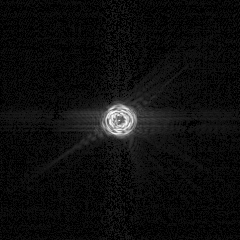

In [5]:
simshow(experimentalData.ptychogram[:, :, 1], γ=0.3)

# 3. Load into ReconstructionCPM

In [6]:
reconstruction = ReconstructionCPM(experimentalData, cuda=true);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/utils_calc.jl:91


In [7]:
# transpose is necessary in this case
reconstruction.encoder = reconstruction.encoder'

2×1600 adjoint(::Matrix{Float32}) with eltype Float32:
 -5.92875f-6  -5.78236f-6  -5.63597f-6  …  -2.19583f-7  -7.31944f-8
 -5.92875f-6  -5.92875f-6  -5.92875f-6     -7.31944f-8  -7.31944f-8

In [8]:
reconstruction.encoder .-= mean(reconstruction.encoder, dims=(2,))

2×1600 Matrix{Float32}:
 -2.92778f-6  -2.78139f-6  -2.635f-6    …  2.635f-6    2.78139f-6  2.92778f-6
 -2.92777f-6  -2.92777f-6  -2.92777f-6     2.92778f-6  2.92778f-6  2.92778f-6

# 4. Choose engine

In [133]:
params = Params(fftshiftFlag = false, 
                 transposePtychogram = false, 
                 comStabilizationSwitch = true,
                 randPositionOrder = true)

engine = PtyLab.ePIE(betaProbe = 0.5f0, betaObject = 0.5f0, numIterations = 50)

ePIE{Float32}
  betaProbe: Float32 0.5f0
  betaObject: Float32 0.5f0
  numIterations: Int64 50


In [134]:
reconstruction.npsm = 2

2

In [135]:
reconstruction.entrancePupilDiameter = reconstruction.Np/3 * reconstruction.dxp

2.9277777002789662e-6

# 5. Reconstruct

In [136]:
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

In [137]:
@time p, o = PtyLab.reconstruct(engine, params, reconstruction);

┌ Warning: gimmel is currently estimated as `eps(Float32)`
└ @ PtyLab ~/.julia/dev/PtyLab.jl/src/Engines.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


 53.819537 seconds (82.89 M allocations: 6.610 GiB, 1.63% gc time)


In [138]:
size(reconstruction.object)

(960, 960, 1, 1, 1, 1)

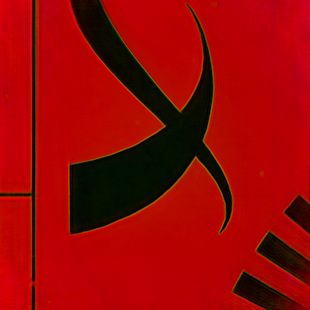

In [139]:
simshow(select_region(Array(reconstruction.object[:, :, 1,1,1,1]), new_size=(310,310)))

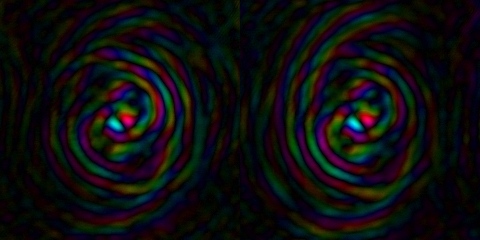

In [140]:
[simshow(Array(reconstruction.probe[:, :, 1,1,1,1])) simshow(Array(reconstruction.probe[:, :, 1,1,2,1]))]